In [2]:
# in order to install the required packages for the snn conversion, 
# you need the following packages
# furthemore you must have installed miniconda or anaconda
# and activated a virtual environment to execute the following commands

# %conda install akida
# %conda install cnn2snn
# %conda install akida-models

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd

/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-06 15:11:34.503191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
# Akida specific imports
from akida import Model

In [88]:
ds_train, ds_train_info = tfds.load('wider_face', split='train', shuffle_files=True, with_info=True)
ds_train = ds_train.filter(lambda x: len(x["faces"]["bbox"]) < 2) 
ds_test, ds_test_info = tfds.load('wider_face', split='test', shuffle_files=True, with_info=True)
ds_test = ds_test.filter(lambda x: len(x["faces"]["bbox"]) < 2) 

,faces/bbox,faces/blur,faces/expression,faces/illumination,faces/invalid,faces/occlusion,faces/pose,image,image/filename
0,,0,False,False,False,0,False,,38--Tennis/38_Tennis_Tennis_38_759.jpg
1,,0,False,False,False,0,False,,13--Interview/13_Interview_Interview_On_Location_13_936.jpg
2,,0,False,False,False,0,True,,40--Gymnastics/40_Gymnastics_Gymnastics_40_804.jpg

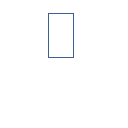
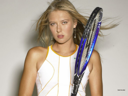
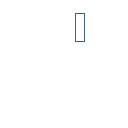
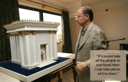
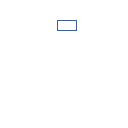
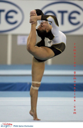

In [89]:
tfds.as_dataframe(ds_train.take(3), ds_train_info)

In [90]:
from tensorflow.image import resize
import numpy as np

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""

  return tf.cast(resize(image, [224,224]),tf.float32) / 255., label

In [91]:
ds_train = ds_train.map(lambda x : normalize_img(image=x["image"], label=x["faces"]["bbox"]), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_train_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [92]:
ds_test = ds_test.map(lambda x : normalize_img(image=x["image"], label=x["faces"]["bbox"]), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(ds_test_info.splits['test'].num_examples)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [93]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
from tensorflow.keras import Sequential

# Retrieve the float model with pretrained weights and load it
model_file = get_file(
    "akidanet_imagenet_224_alpha_50.h5",
    "http://data.brainchip.com/models/akidanet/akidanet_imagenet_224_alpha_50.h5",
    cache_subdir='models/akidanet_imagenet')
model = load_model(model_file)

In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


In [95]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_496563/2945507742.py", line 1, in <module>
      model.fit(
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/keras/backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [128,1000] and labels shape [512]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_20508]

In [6]:
df : tfds.core.as_dataframe.StyledDataFrame = tfds.as_dataframe(ds_train,ds_info)

In [7]:
df.head(2)

,faces/bbox,faces/blur,faces/expression,faces/illumination,faces/invalid,faces/occlusion,faces/pose,image,image/filename
0,"[[0.077473186, 0.6298828, 0.12753278, 0.659179...","[1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 2, ...","[False, False, False, False, True, False, Fals...","[[[161, 137, 127], [147, 125, 114], [153, 133,...",b'3--Riot/3_Riot_Riot_3_84.jpg'
1,"[[0.236671, 0.37890625, 0.38361508, 0.4453125]...","[1, 2]","[False, False]","[False, False]","[False, False]","[0, 2]","[False, False]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",b'44--Aerobics/44_Aerobics_Aerobics_44_1009.jpg'


In [8]:
df : pd.DataFrame = df.drop(['faces/blur', 'faces/illumination', 'faces/invalid', 'faces/occlusion', 'faces/pose', 'image/filename'], axis="columns")

In [9]:
df.head(2)

,faces/bbox,faces/expression,image
0,"[[0.077473186, 0.6298828, 0.12753278, 0.659179...","[False, False, False, False, False, False, Fal...","[[[161, 137, 127], [147, 125, 114], [153, 133,..."
1,"[[0.236671, 0.37890625, 0.38361508, 0.4453125]...","[False, False]","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [11]:
df = df.apply(lambda x : pd.Series(normalize_img(x["image"], x["faces/bbox"])), axis="columns")

In [12]:
df.head(2)

,0,1
0,"(((tf.Tensor(0.6313726, shape=(), dtype=float3...","[[0.077473186, 0.6298828, 0.12753278, 0.659179..."
1,"(((tf.Tensor(0.0, shape=(), dtype=float32), tf...","[[0.236671, 0.37890625, 0.38361508, 0.4453125]..."


In [15]:
df.columns

RangeIndex(start=0, stop=2, step=1)

In [17]:
model_keras.fit(
    x = df[0],
    y = df[1], 
    epochs = 10
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).

In [24]:
from akida_models import akidanet_imagenet_pretrained

# Use a quantized model with pretrained quantized weights
model_keras_quantized_pretrained = akidanet_imagenet_pretrained(0.5)
model_keras_quantized_pretrained.summary()

ImportError: cannot import name 'CalibrableVariable' from 'quantizeml.layers' (/lhome/fimilak/miniconda3/envs/studienarbeit/lib/python3.10/site-packages/quantizeml/layers/__init__.py)

In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__normalize_img() missing 1 required positional argument: 'label'


In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [20]:
import linecache
import re
import os

FILEDIR = "B:/Benutzer/Filip Milak/Downloads/wider_face_split/"

file = open(FILEDIR + 'wider_face_val_bbx_gt.txt', 'r')

def count_lines(file):
    lines_quantity = 0
    while True:
        buffer = file.read(1024 * 8192)
        if not buffer:
            break
        lines_quantity += buffer.count('\n')
    file.close()
    return lines_quantity


lines = count_lines(file)

for i in range(lines):
    line = linecache.getline(FILEDIR + 'wider_face_val_bbx_gt.txt', i)
    if re.search('jpg', line):
        position = line.index('/')
        file_name = line[position + 1: -5]
        folder_name = line[:position]
        print(file_name)
        i += 1
        face_count = int(linecache.getline(FILEDIR + 'wider_face_val_bbx_gt.txt', i))
        
        j = 0
        
        for j in range(face_count):
            box_line = linecache.getline(FILEDIR + 'wider_face_val_bbx_gt.txt',i + j + 1)  # x1, y1, w, h, x1,y1 
            po_x1 = box_line.index(' ')
            x1 = box_line[:po_x1]
            po_y1 = box_line.index(' ', po_x1 + 1)
            y1 = box_line[po_x1:po_y1]
            po_w = box_line.index(' ', po_y1 + 1)
            w = box_line[po_y1:po_w]
            po_h = box_line.index(' ', po_w + 1)
            h = box_line[po_w:po_h]
            coordinates = x1 + y1 + w + h
            # print(coordinates)
            if not (os.path.exists(FILEDIR + "wider_face_val\\" + folder_name)):
                os.makedirs(FILEDIR + "wider_face_val\\" + folder_name)
            with open(FILEDIR + "wider_face_val\\" + folder_name + "\\" + file_name + ".txt", 'a') as f:
                f.write(coordinates + "\n")
        i += i + j + 1

0_Parade_marchingband_1_465
0_Parade_Parade_0_628
0_Parade_marchingband_1_765
0_Parade_Parade_0_194
0_Parade_marchingband_1_379
0_Parade_Parade_0_814
0_Parade_Parade_0_470
0_Parade_marchingband_1_1045
0_Parade_marchingband_1_556
0_Parade_Parade_0_829
0_Parade_marchingband_1_593
0_Parade_Parade_0_29
0_Parade_Parade_0_72
0_Parade_Parade_0_205
0_Parade_marchingband_1_881
0_Parade_marchingband_1_490
0_Parade_Parade_0_125
0_Parade_Parade_0_120
0_Parade_marchingband_1_476
0_Parade_marchingband_1_620
0_Parade_Parade_0_960
0_Parade_marchingband_1_488
0_Parade_Parade_0_901
0_Parade_marchingband_1_822
0_Parade_marchingband_1_353
0_Parade_marchingband_1_74
0_Parade_marchingband_1_234
0_Parade_marchingband_1_359
0_Parade_Parade_0_266
0_Parade_Parade_0_275
0_Parade_Parade_0_478
0_Parade_Parade_0_913
0_Parade_marchingband_1_172
0_Parade_marchingband_1_309
0_Parade_marchingband_1_360
0_Parade_Parade_0_472
0_Parade_marchingband_1_517
0_Parade_marchingband_1_188
0_Parade_Parade_0_917
0_Parade_Parade_0_

In [22]:
import os
import json

FILEDIR = "B:\Benutzer\Filip Milak\Downloads\wider_face_split\wider_face_val"

for filelist in os.walk(FILEDIR):
    for file_dir in filelist[1]:
        for subfilelist in os.walk(''.join([FILEDIR, "/", file_dir])):
            for file in subfilelist[2]:
                if file.endswith(".txt"):
                    with open(''.join([FILEDIR, "/", file_dir, "/", file]), 'r') as txtfile:
                        dict = {}
                        for i, line in enumerate(txtfile.readlines()):
                            num = line.split(' ')
                            dict[i] = {
                                'x': [int(num[0]), int(num[0]) + int(num[2]), int(num[0]) + int(num[2]), int(num[0])],
                                'y': [int(num[1]), int(num[1]), int(num[1]) + int(num[3]), int(num[1]) + int(num[3])]
                            }
                        with open(''.join([FILEDIR, "/", file_dir, "/", file[:-4], ".json"]), 'w+') as jsonfile:
                            jsonfile.write(json.dumps(dict))
                        jsonfile.close()
                    txtfile.close()

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

h:\Programme\Miniconda\envs\studienarbeit\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from akida_models import akidanet_imagenet_pretrained

# Use a quantized model with pretrained quantized weights
model_keras_quantized_pretrained = akidanet_imagenet_pretrained(0.5)
model_keras_quantized_pretrained.summary()